# 그림 보조

*KU LeeDongGyu*

### Module

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [20]:
from lrn import LRN #만든 모듈, class
from f1score import macro_f1score, weighted_f1score

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Paper'


## 1. Data Preprocessing
---

### 1) Data Import

In [23]:
# 바꿔서 살펴 볼 것들
# CALTECH, CIFAR100, FER, MIT
data_name = 'CALTECH'
gan_type = 'No_GAN'
number = '1'
size = 227 # sizes after cropping
super_size = 256 # sizes before cropping 
input_sizes = (size,size,3)
batch_sizes = 128
weight_decay = 1e-4
epochs = 70

In [24]:
# 참고 : https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216
# setting the seed number for random number generation for reproducibility.

from numpy.random import seed
import random


if number=='1':
    seed_num = 200225
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='2':
    seed_num = 727
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='3':
    seed_num = 115
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='4':
    seed_num = 501
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='5':
    seed_num = 517
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [25]:
# data import

if data_name=='FER' :
    x_train =  np.zeros(28698)
    x_valid = np.zeros(3589)
    x_test = np.zeros(3588)
    classes = 7 
    tr_center = [0.50793296, 0.50793296, 0.50793296]
elif data_name=='MIT':
    x_train = np.zeros(12466)
    x_valid = np.zeros(1564)
    x_test = np.zeros(1590)
    classes = 67 
    tr_center = [0.47916578, 0.42029615, 0.36046057]
elif data_name=='CALTECH':
    x_train = np.zeros(24510)
    x_valid = np.zeros(2980)
    x_test = np.zeros(3118)
    classes = 257
    tr_center = [0.51397761, 0.49525248, 0.46555727]
elif data_name=='CIFAR100':
    x_train = np.zeros(44923)
    x_valid = np.zeros(5077)
    x_test = np.zeros(10000)
    classes = 100
    tr_center = [0.53442983, 0.51355958, 0.46462564]

In [26]:
dir = os.path.join(os.getcwd(),data_name,gan_type)

In [27]:
# data import
incep_data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'Inception_ResNet_v2.txt'))
res_data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'ResNet50.txt'))

In [28]:
# inception resnet v2
incep_epochs=incep_data[:,0]
incep_loss=incep_data[:,1]
incep_val_loss=incep_data[:,2]
incep_acc=incep_data[:,3]
incep_val_acc=incep_data[:,4]
incep_top5_acc=incep_data[:,5]
incep_val_top5_acc=incep_data[:,6]

In [29]:
# resnet50
res_epochs=res_data[:,0]
res_loss=res_data[:,1]
res_val_loss=res_data[:,2]
res_acc=res_data[:,3]
res_val_acc=res_data[:,4]
res_top5_acc=res_data[:,5]
res_val_top5_acc=res_data[:,6]

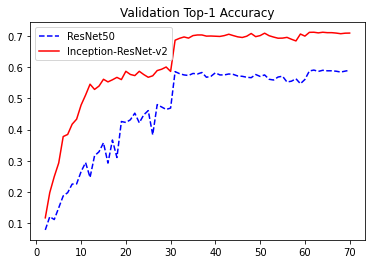

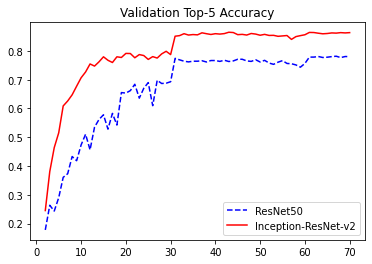

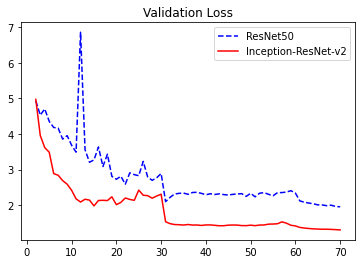

In [31]:
plt.plot(res_epochs[1:],res_val_acc[1:],'b--',label='ResNet50')
plt.plot(incep_epochs[1:],incep_val_acc[1:],'r',label='Inception-ResNet-v2')
plt.title('Validation Top-1 Accuracy')
plt.legend()
plt.savefig('top-1.png', dpi = 400)
plt.figure()

plt.plot(res_epochs[1:],res_val_top5_acc[1:],'b--',label='ResNet50')
plt.plot(incep_epochs[1:],incep_val_top5_acc[1:],'r',label='Inception-ResNet-v2')
plt.title('Validation Top-5 Accuracy')
plt.legend()
plt.savefig('top-5.png', dpi = 400)
plt.figure()

plt.plot(res_epochs[1:],res_val_loss[1:],'b--',label='ResNet50')
plt.plot(incep_epochs[1:],incep_val_loss[1:],'r',label='Inception-ResNet-v2')
plt.title('Validation Loss')
plt.legend()
plt.savefig('loss.png', dpi = 400)
plt.show()